# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Introduction


In this project I will load and manipulate a music app dataset similar to Spotify with Spark to engineer relevant features for predicting churn. Where Churn is cancelling their service altogether. By identifying these customers before they churn, the business can offer discounts and incentives to stay thereby potentially saving the business revenue. This workspace contains a tiny subset (128MB) of the full dataset available (12GB).




### Project Overview

*Sparkify* is an fictional music streaming service by Udacity to emulate a real streaming service like Spotify. The Sparkify users can stream the music with the free subscription plan with ads or the paid subscription plan without ads. Apart from using the service to listen to the music, users can swipe up or down, add songs to playlists, or even add friends. Users can change their subscription plan by *upgrading* it from free to paid, *downgrading* from paid to free, or stop using the service altogether by *canceling* the subscription. 

Any user interaction with the service triggers a certain log event that represents our data. A log contains information about the event time, identifies the session and the user, includes some of user attributes, subscription plan, user interaction type etc. 
 
We will use the mini dataset of 128MB to get used to our data and do all the necessary work. Since we are working with huge amount of data, we will use **Apache Spark** analytics engine for processing large datasets with Spark SQL query language for structured data processing.

### Problem statement

Business-wise, the word "**churn**" is used to refer to customers that leave the company’s service over a given time period. The businesses strive to identify the potential users who are likely to leave *before* they actually leave the service in order to take actions to retain them. Some estimate that it may costs five or six times as much to acquire a new customer than it does to retain the ones you have (https://baremetrics.com/academy/churn).

Our churned users are defined as those who **downgrade** or **cancel** the subscription. For the reasons explained later on *we will not mix* users who cancelled the subscription with users who downgraded. We’ll separately address these two churn types of users.

The identification of potential churned users is a **binary classification problem**: either a user is *churned* or *non-churned*. In order to be able to properly classify users we will perform exploratory data analysis against sample data, then we’ll engineer the features that we will find important for churn classification, and finally, we’ll exercise modelling with selected features using various learning methods. 

The solution of our problem is to create a **machine learning model** that can provide prediction results achieving the *project goal* according to the chosen metrics as described in the next section.

### Metrics

Since we are interested not only in precision (ensuring we identify as many users susceptible to churn as possible), but also in recall (ensuring the users we identify are actually likely to churn, since they’ll, for example, be proposed special offers), we propose to use [F1-score](https://en.wikipedia.org/wiki/F1_score) to measure our machine learning classifier performance.

### Project goal

**Our project is all about the prediction ability.** After all, what is it good for all the data exploratory work, all the feature engineering creativity and nice-looking code if at the end our model doesn't work?  

The project goal is to reach **0.9** of F1-score. We'll be also satisfied with a bit lower value but we'll definetely not be satisfied with the value below **0.8**.

* The data is available in form of user events in json format
* Data needs pre-processing in form of
 * Clean up of missing or unusable data
 * Feature extraction to extract meaningful information
* On the next step, the pre-processed data is used to train several supervised machine learning model.
* The best suited model is then chosen to predict future data

Let's go!

In [1]:
# --- import libraries ---
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, StringType, TimestampType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.classification import GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import Evaluator

import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# ------------------------

%matplotlib inline

In [2]:
# set colors for all charts parameters for custom plot
pltParams = {'axes.facecolor'    : '#EAEAF2', # background color
             'axes.spines.top'   : False,     # disabled borders
             'axes.spines.bottom': False,
             'axes.spines.left'  : False,
             'axes.spines.right' : False,
             'grid.color'        : 'white',   # set grid color
             'grid.linestyle'    : '-'}       # define grid line style

# update rcParams for all plots
plt.rcParams.update(pltParams)

<hr>

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [4]:
# set constant
CONST_DATAFILE            = 'mini_sparkify_event_data.json'
CONST_PROCESSED_DATAFILE  = 'mini_sparkify_processed.json'

CONST_COLOR_1 = '#1F77B4' # blue
CONST_COLOR_2 = '#7F006E' # purpur
CONST_COLOR_3 = '#5F9E6E' # green

In [5]:
# get configuration
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1623867538051'),
 ('spark.driver.port', '59058'),
 ('spark.driver.host', '20IAV101844N-0.iavgroup.local'),
 ('spark.rdd.compress', 'True'),
 ('spark.sql.warehouse.dir',
  'file:/E:/Udacity/Data_Scientist_Nanodegree/06_Data%20Scientist%20Capstone/Lesson%2028%20-%20Project%20-%20Data%20Scientist%20Capstone/project_Sparkify/spark-warehouse'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.app.startTime', '1623867535401'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
# load data and get a fist look
data_raw = spark.read.json( CONST_DATAFILE )

In [7]:
# review columns
data_raw.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### at the first place -- get a first look into the data

In [8]:
# number of raw events
print('Number of rows in raw dataset: ' + str( data_raw.count() ))
print('amount of columns: ' + str( len(data_raw.columns) ))

Number of rows in raw dataset: 284159
amount of columns: 19


In [9]:
# there seem to be 2 ID columns: sessionId and userId
data_raw.describe("sessionId").show()
data_raw.describe("userId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            284158|
|   mean|1031.7338628509492|
| stddev| 721.5467283054604|
|    min|                 1|
|    max|              2474|
+-------+------------------+

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            284158|
|   mean|60172.507530366136|
| stddev|109405.45883220363|
|    min|                  |
|    max|                99|
+-------+------------------+



In [10]:
print('Number of sessions before cleaning: ' + str(data_raw.select('sessionId').distinct().count()))
print('Number of users before cleaning: ' + str(data_raw.select('userId').distinct().count()))

Number of sessions before cleaning: 2342
Number of users before cleaning: 227


In [11]:
# let's ensure the session and user ID values are valid
print('Are the session and user ID values valid:')
data_raw.select('userId').where( F.isnull(data_raw.userId) ).show()
data_raw.select('sessionId').where( F.isnull(data_raw.sessionId)).show()

data_raw.groupBy('userId').agg({'userId':'count'}).where(data_raw.userId == '') \
    .withColumnRenamed('count(userId)', 'total empty userID rows').show()

data_raw.groupBy('sessionId').agg({'sessionId':'count'}).where(data_raw.sessionId == '') \
    .withColumnRenamed('count(sessionId)', 'total empty sessionId rows').show()

print('Number of rows without user ID: ' + str( data_raw.where(data_raw.userId =='').count() ))

Are the session and user ID values valid:
+------+
|userId|
+------+
+------+

+---------+
|sessionId|
+---------+
+---------+

+------+-----------------------+
|userId|total empty userID rows|
+------+-----------------------+
|      |                   8275|
+------+-----------------------+

+---------+--------------------------+
|sessionId|total empty sessionId rows|
+---------+--------------------------+
+---------+--------------------------+

Number of rows without user ID: 8275


### at the second place -- get a close look into the data

In [12]:
# implement a helper function
def getUniqueValuesOf(data, column):
    """
    Return the unique values with row count of a given column in the data set.
    
    param: data - DataFrame - The data set. 
    param: column - String  - The name of a target column.
    @return - DataFrame - A dataframe query sorted by count descending.
    """
    
    return data.groupby(column).count().sort(F.desc('count'))

In [13]:
# what is about the colum: auth / authentication level
getUniqueValuesOf(data_raw, 'auth').show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|275831|
|Logged Out|  8178|
|     Guest|    97|
| Cancelled|    52|
|      null|     1|
+----------+------+



In [14]:
# what is about the colum: gender / gender of a user
getUniqueValuesOf(data_raw, 'gender').show()

+------+------+
|gender| count|
+------+------+
|     F|153015|
|     M|122868|
|  null|  8276|
+------+------+



In [15]:
# what is about the colum: level / subscription level of a user
getUniqueValuesOf(data_raw, 'level').show()

+-----+------+
|level| count|
+-----+------+
| paid|226212|
| free| 57946|
| null|     1|
+-----+------+



In [16]:
# what is about the colum: location / location of a user (containing city, state)
getUniqueValuesOf(data_raw, 'location').show(5, False)

+-------------------------------------+-----+
|location                             |count|
+-------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA   |29955|
|New York-Newark-Jersey City, NY-NJ-PA|23644|
|Boston-Cambridge-Newton, MA-NH       |13574|
|Houston-The Woodlands-Sugar Land, TX |9303 |
|null                                 |8276 |
+-------------------------------------+-----+
only showing top 5 rows



In [17]:
# what is about the colum: method / http request method
getUniqueValuesOf(data_raw, 'method').show()

+------+------+
|method| count|
+------+------+
|   PUT|258922|
|   GET| 25236|
|  null|     1|
+------+------+



In [18]:
# what is about the colum: status / http response status code
getUniqueValuesOf(data_raw, 'status').show(5, False)

+------+------+
|status|count |
+------+------+
|200   |257732|
|307   |26172 |
|404   |254   |
|null  |1     |
+------+------+



In [19]:
# what is about the colum: page / type of a user interaction
getUniqueValuesOf(data_raw, 'page').show(30, False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |226277|
|Home                     |14334 |
|Thumbs Up                |12455 |
|Add to Playlist          |6473  |
|Add Friend               |4196  |
|Roll Advert              |3909  |
|Login                    |3209  |
|Logout                   |3195  |
|Thumbs Down              |2530  |
|Downgrade                |2041  |
|Help                     |1712  |
|Settings                 |1504  |
|About                    |916   |
|Upgrade                  |496   |
|Save Settings            |308   |
|Error                    |254   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancellation Confirmation|52    |
|Cancel                   |52    |
|Register                 |18    |
|Submit Registration      |5     |
|null                     |1     |
+-------------------------+------+



In [20]:
# have a look at the raw datas
data_raw.take(2)

[Row(_corrupt_record=None, artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(_corrupt_record=None, artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [21]:
data_no_user_or_session = data_raw.filter( (data_raw.userId == '') | ( data_raw.sessionId == '') )
data_no_user_or_session.select('page').dropDuplicates().show()

print('Number of records having no userId or sessionId:       ', data_no_user_or_session.count())
print('Number of records having sessionId but missing userId: ', data_no_user_or_session.filter( (data_raw.userId == '') & (data_raw.sessionId != '') ).count())
print('Number of records having userId but missing sessionId: ', data_no_user_or_session.filter( (data_raw.userId != '') & (data_raw.sessionId == '') ).count())

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+

Number of records having no userId or sessionId:        8275
Number of records having sessionId but missing userId:  0
Number of records having userId but missing sessionId:  0


**Note**

As can be seen, there are 8275 records without an association of userId or sessionId. If we then look at the page column for these records, it becomes clear that these records belong to unregistered users. 

We also see that both sessionId and userId are missing for these records. In this case, unfortunately, we cannot populate these records either. Upon further inspection, it also appears that the sessionId is rotated and belongs to different users over different time periods. Therefore, in this case, we cannot use the sessionId information to populate the userId.

As a result, we cannot gain any meaningful insights from these records and should rather exclude these records from the analysis.

In [22]:
data_user_log_valid = data_raw.dropna(how='any', subset=['userId', 'sessionId']);
data_user_log_valid = data_user_log_valid.where( data_user_log_valid.userId != '' )

Let's extract the 'state' information from the location:

In [23]:
func_getState = F.udf(lambda x: x[-2:])
data_user_log_valid = data_user_log_valid.withColumn('state', func_getState( data_user_log_valid.location ))

Let's convert this into a better understandable timestamp format:

In [24]:
func_getTimestamp = F.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0), TimestampType())
data_user_log_valid = data_user_log_valid.withColumn('timestamp', func_getTimestamp( data_user_log_valid.ts ))

<hr>

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [25]:
data_count_by_page   = data_user_log_valid.groupby('page').agg(F.count('page').alias('cnt')).sort('page').toPandas()
data_count_by_gender = data_user_log_valid.groupby('gender').agg(F.count('gender').alias('cnt')).sort('gender').toPandas()
data_count_by_level  = data_user_log_valid.groupby('level').agg(F.count('level').alias('cnt')).sort('level').toPandas()

In [26]:
data_count_by_status = data_user_log_valid.groupby('status').agg(F.count('status').alias('cnt')) \
                          .withColumn('status', F.col('status').cast(StringType())).sort('status').toPandas()
data_users_by_gender = data_user_log_valid.select('userId', 'gender').dropDuplicates() \
                          .groupBy('gender').agg( F.count('gender').alias('cnt') ).sort('gender').toPandas()

In [27]:
# set window
w = Window.partitionBy('userId')
data_user_current_level = data_user_log_valid.withColumn('maxTs', F.max('ts').over( w ))\
                            .where(F.col('ts') == F.col('maxTs'))\
                            .drop('maxTs')\
                            .select('userId', 'level').dropDuplicates()

In [28]:
data_users_by_level = data_user_current_level.groupBy('level')\
                        .agg( F.count('level').alias('cnt') )\
                        .sort('level').toPandas()

In [29]:
data_pages = data_count_by_page.sort_values(by=['cnt'])

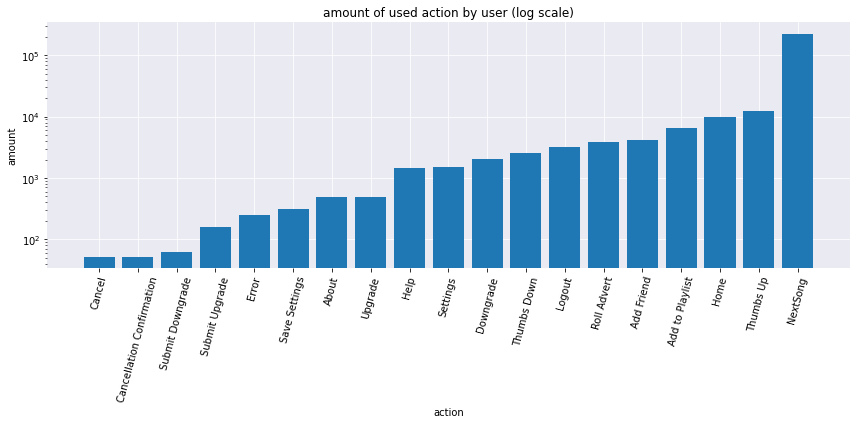

In [30]:
# plot a diagram - use log scale for better visualisaton
fig, ax = plt.subplots( figsize=(12,6) )

ax.bar(data_pages.page, data_pages.cnt, log=True, color=CONST_COLOR_1, zorder=3)
plt.xticks(rotation=75)

plt.title("amount of used action by user (log scale)")
plt.ylabel('amount')
plt.xlabel('action')

plt.rcParams.update(pltParams)
plt.tight_layout()
plt.grid(True)
plt.show()

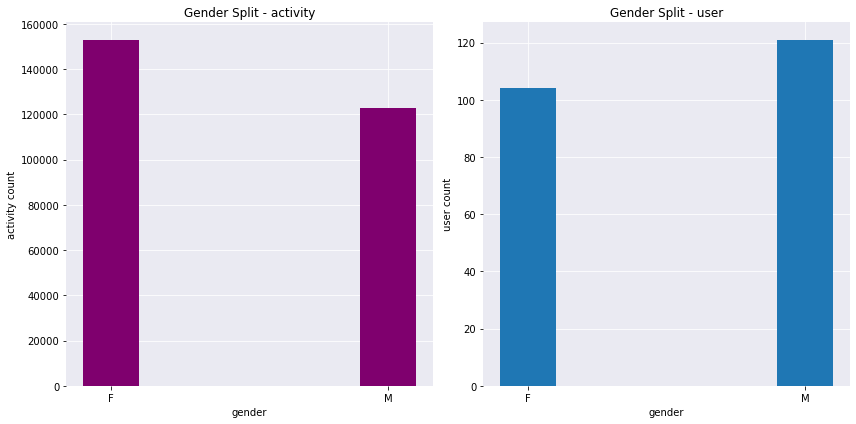

In [31]:
# plot a diagram
fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].bar(data_count_by_gender.gender, data_count_by_gender.cnt, align='center', width=0.2, color=CONST_COLOR_2, zorder=3)
axs[0].set_title('Gender Split - activity')
axs[0].set_xlabel('gender')
axs[0].set_ylabel('activity count')
axs[0].grid(True)

axs[1].bar(data_users_by_gender.gender, data_users_by_gender.cnt, align='center', width=0.2, color=CONST_COLOR_1, zorder=3)
axs[1].set_title('Gender Split - user')
axs[1].set_xlabel('gender')
axs[1].set_ylabel('user count')
axs[1].grid(True)

plt.rcParams.update(pltParams)
plt.tight_layout()
plt.show()

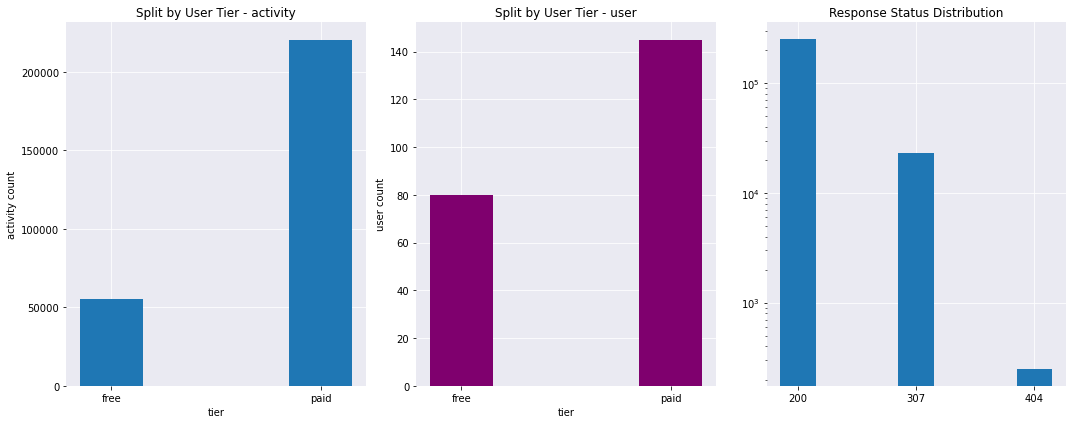

In [32]:
# plot a diagram
fig, axs = plt.subplots(1, 3, figsize=(15,6))

axs[0].bar(data_count_by_level.level, data_count_by_level.cnt, align='center', width=0.3, color=CONST_COLOR_1, zorder=3)
axs[0].set_title('Split by User Tier - activity')
axs[0].set_xlabel('tier')
axs[0].set_ylabel('activity count')
axs[0].grid(True)

axs[1].bar(data_users_by_level.level, data_users_by_level.cnt, align='center', width=0.3, color=CONST_COLOR_2, zorder=3)
axs[1].set_title('Split by User Tier - user')
axs[1].set_xlabel('tier')
axs[1].set_ylabel('user count')
axs[1].grid(True)

axs[2].bar(data_count_by_status.status, data_count_by_status.cnt, log=True, width=0.3, color=CONST_COLOR_1, zorder=3)
axs[2].set_title('Response Status Distribution')
axs[2].grid(True)

plt.rcParams.update(pltParams)
plt.tight_layout()
plt.show()

**Note**

The `Page` column represents user-initiated events and can be used here to extract meaningful features for modeling and analysis.

The breakdown by `gender` is approximately the same and does not give a noticeable difference at first glance. It is tested to see if there is a bias in migrated users based on gender.

`Level` contains whether the user has a free or paid subscription. Here it seems that "paid" users are much more active. However, it could be that this difference is also due to the larger number of paid users in the available dataset.

`Status` represents the HTTP response code received. The 4xx error codes represent the error and we can see if receiving too many errors was a factor.

In [33]:
# evaluate: different registration value for same userId with value 0
data_uid_reg_cnt = data_user_log_valid.select('userId', 'registration') \
                    .dropDuplicates() \
                    .groupBy('userId', 'registration') \
                    .count().withColumnRenamed('count', 'cnt')

print('Num Records showing different registration value for same userId', data_uid_reg_cnt.where('cnt > 1  or cnt < 1').count())

Num Records showing different registration value for same userId 0


**Note**

Num records with different registration values for the same userId with value 0.

`Registration` represents the time of registration for the specified user. There is a direct relationship between them. Here this column can be used to derive or extract the user lifetime from it.

In [34]:
# evaluate: number of songs played by hour of day
data_play_count_by_hour = data_user_log_valid.where( data_user_log_valid.page=='NextSong' ) \
                            .groupby( F.hour(data_user_log_valid.timestamp ).alias('hour') ) \
                            .count().orderBy('hour').toPandas()

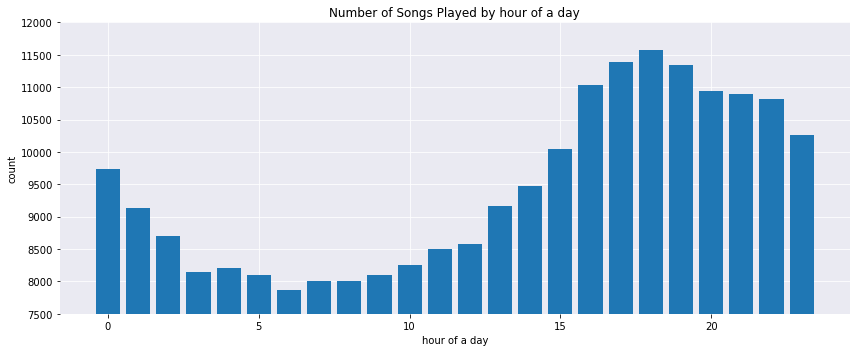

In [35]:
# plot a diagram
fig, ax = plt.subplots(figsize=(12,5))

ax.bar(data_play_count_by_hour['hour'], data_play_count_by_hour['count'], color=CONST_COLOR_1, zorder=3)
ax.set_xlabel('hour of a day')
ax.set_ylabel('count')

plt.ylim(7500,12000)
plt.title("Number of Songs Played by hour of a day")
plt.rcParams.update(pltParams)
plt.tight_layout()
plt.grid(True)
plt.show()

**Note**

Here it is very noticeable that many users use this platform most in the late afternoon or evening between 4-6pm and then stay on this platform for a very long time. Here one could assume that they use this platform more at home and less throughout the day. Thus, the utilization of the network load, the associated power consumption and also the accessibility of the server or the service could be included accordingly in the economic analysis. Efficiency and cost savings.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

**Note: What is Churn?**

We define "churn" as any user who cancels services/stops using the service during a certain period of time. The data is then provided with an additional column "churned", which has the value "churned" for users who have cancelled their services. Otherwise, the value is "active". Also, a "phase" column is created, which has the value 0 for events before the user decides to downgrade services, and 1 after.

In [36]:
func_churn = F.udf(lambda x: 'churned' if x == 1 else 'active')

# create downgrade label
func_downgradeEvent = F.udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
data_user_log_valid = data_user_log_valid.withColumn("downgraded", func_downgradeEvent("page"))

# set window
w = Window.partitionBy('userId').orderBy(F.desc('ts')).rangeBetween( Window.unboundedPreceding,0 )
data_user_log_valid = data_user_log_valid.withColumn('phase', F.sum('downgraded').over(w))

func_cancelledEvent = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
data_user_log_valid = data_user_log_valid.withColumn('cancelled', func_cancelledEvent(data_user_log_valid.page) )

In [37]:
# mark user who've ever downgraded as churn
# set window
w = Window.partitionBy('userId')
data_user_log_valid = data_user_log_valid.withColumn('churned', func_churn(F.max('cancelled').over(w)))

In [38]:
data_user_log_valid.select(['userId', 'downgraded', 'phase', 'cancelled', 'churned']).take(5)

[Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active'),
 Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active'),
 Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active'),
 Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active'),
 Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active')]

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [39]:
data_churned_split = data_user_log_valid.select(['userId', 'churned']) \
                        .dropDuplicates() \
                        .groupby('churned') \
                        .agg(F.count('churned').alias('cnt'))\
                        .sort('churned') \
                        .toPandas()

In [40]:
data_churn_by_gender = data_user_log_valid.select(['gender', 'userId', 'churned']) \
                        .dropDuplicates() \
                        .groupby('churned', 'gender') \
                        .count().withColumnRenamed('count', 'cnt') \
                        .toPandas() \
                        .pivot(index='churned', columns='gender')['cnt']

In [41]:
# set window
w = Window.partitionBy('userId')
data_churn_by_tier = data_user_log_valid.withColumn('maxTs', F.max('ts').over(w))\
                        .where(F.col('ts') == F.col('maxTs'))\
                        .drop('maxTs')\
                        .select('userId', 'churned', 'level') \
                        .dropDuplicates() \
                        .groupby('churned', 'level') \
                        .count().withColumnRenamed('count', 'cnt') \
                        .toPandas() \
                        .pivot(index='churned', columns='level')['cnt']

In [42]:
data_user_ad_count = data_user_log_valid.where(data_user_log_valid.page=='Roll Advert') \
                        .groupBy('churned') \
                        .count() \
                        .withColumnRenamed('count', 'adCount') \
                        .sort('churned') \
                        .toPandas() \
                        .merge(data_churned_split)

In [43]:
data_user_ad_count['avg_count'] = data_user_ad_count.adCount / data_user_ad_count.cnt

In [44]:
# implement a helper function
def func_makeAutoPercent(values):
    def func_autoPercentHelper(pct):
        total = sum(values)
        val = int( round( pct*total/100.0 ) )
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    
    return func_autoPercentHelper
# --------------

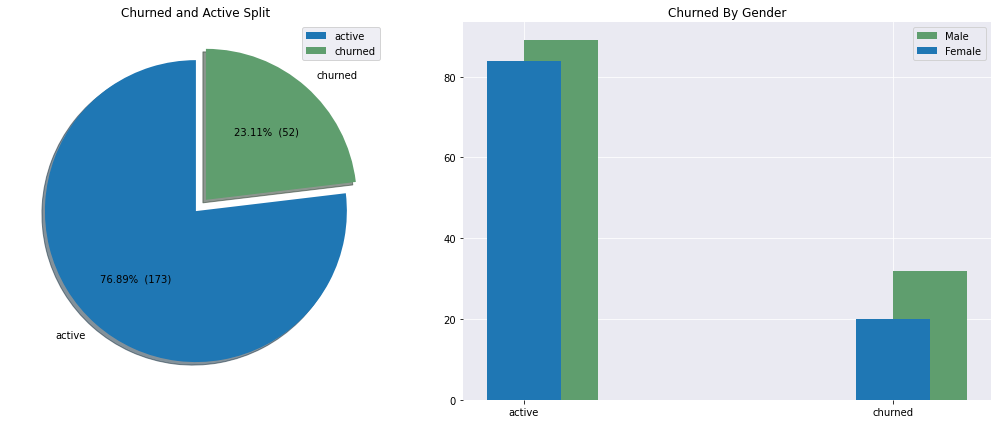

In [45]:
# plot a diagram
fig, axs = plt.subplots(1, 2, figsize=(15,6))

axs[0].pie( data_churned_split.cnt,
            explode=(0,0.1),
            labels=data_churned_split.churned, 
            colors=[CONST_COLOR_1,CONST_COLOR_3], ##2CA02C 7F006E
            autopct=func_makeAutoPercent( data_churned_split.cnt ),
            shadow=True,
            startangle=90)

axs[0].set_title('Churned and Active Split')
axs[0].legend(loc='upper right')

axs[1].bar([str(i) for i in data_churn_by_gender.index], data_churn_by_gender.M, label="Male", align='edge', width=0.2, color=CONST_COLOR_3, zorder=3)
axs[1].bar([str(i) for i in data_churn_by_gender.index], data_churn_by_gender.F, label="Female", align='center', width=0.2, color=CONST_COLOR_1, zorder=3)
axs[1].set_title('Churned By Gender')
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.rcParams.update(pltParams)
plt.tight_layout()
plt.show()

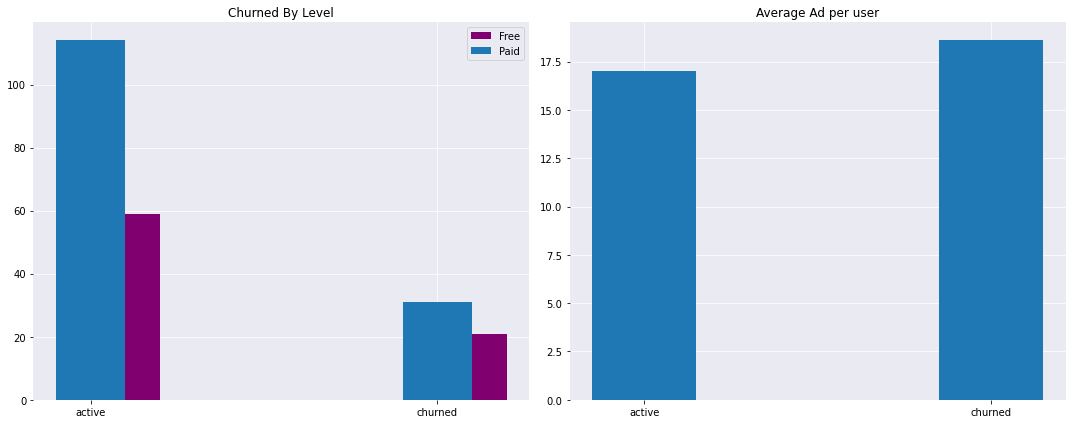

In [46]:
# plot a diagram
fig, axs = plt.subplots(1, 2, figsize=(15,6))

axs[0].bar([str(i) for i in data_churn_by_tier.index], data_churn_by_tier.free, label="Free", align='edge', width=0.2, color=CONST_COLOR_2, zorder=3)
axs[0].bar([str(i) for i in data_churn_by_tier.index], data_churn_by_tier.paid, label="Paid", align='center', width=0.2, color=CONST_COLOR_1, zorder=3)
axs[0].set_title('Churned By Level')
axs[0].legend(loc='upper right')
axs[0].grid(True)

axs[1].bar( data_user_ad_count.churned, data_user_ad_count.avg_count, width=0.3, color=CONST_COLOR_1, zorder=3)
axs[1].set_title('Average Ad per user')
axs[1].grid(True)

plt.rcParams.update(pltParams)
plt.tight_layout()
plt.show()

**Note**

- As we can see, the `churned` is slightly higher among male users.
- A slightly higher proportion of paid users remain active compared to free users.
- The average number of ads seen by churned users is slightly higher than that of active users.

In [47]:
# extract: churned by location
data_churned_users = data_user_log_valid.where( data_user_log_valid.churned=='churned' )\
                        .select('userId','state')\
                        .dropDuplicates() \
                        .groupBy('state')\
                        .agg(F.count('state').alias('cnt')).toPandas()

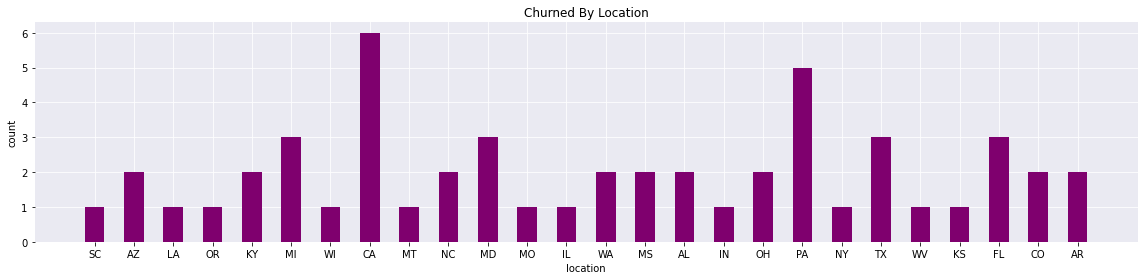

In [48]:
# plot a diagram
fig, axs = plt.subplots(figsize=(16,4))
plt.bar( data_churned_users['state'], data_churned_users['cnt'], width=0.5, color=CONST_COLOR_2, zorder=3)

plt.title("Churned By Location")
plt.ylabel('count')
plt.xlabel('location')

plt.tight_layout()
plt.rcParams.update(pltParams)
plt.grid(True)
plt.show()

**Note**

Above there are some spikes for specific states. For the states "US-CA" for California and "US-PA" for Pennsylvania seem to have the most users who have "churned" relative to the other state. But, since the total numbers are very low (the minimum is 1 and the maximum is 6), therefore I cannot conclude that there is a state bias in churn.

In [49]:
# extract: number of songs
data_weekly_songs_played = data_user_log_valid.where( data_user_log_valid.page=='NextSong' ).select(['timestamp', 'churned'])
data_weekly_songs_played = data_weekly_songs_played.groupBy(F.window( data_weekly_songs_played.timestamp,"1 week"), 'churned').count()
data_weekly_songs_played = data_weekly_songs_played.select('window.start','churned','count').withColumnRenamed('count', 'cnt').toPandas()

In [50]:
# extract: data to plot
data_plot = data_weekly_songs_played.pivot(index='start', columns='churned')['cnt']

In [51]:
data_plot.head()

churned,active,churned
start,,
2018-09-27 02:00:00,6429,3608
2018-10-04 02:00:00,18427,7943
2018-10-11 02:00:00,18054,8611
2018-10-18 02:00:00,22989,5390
2018-10-25 02:00:00,22172,4479


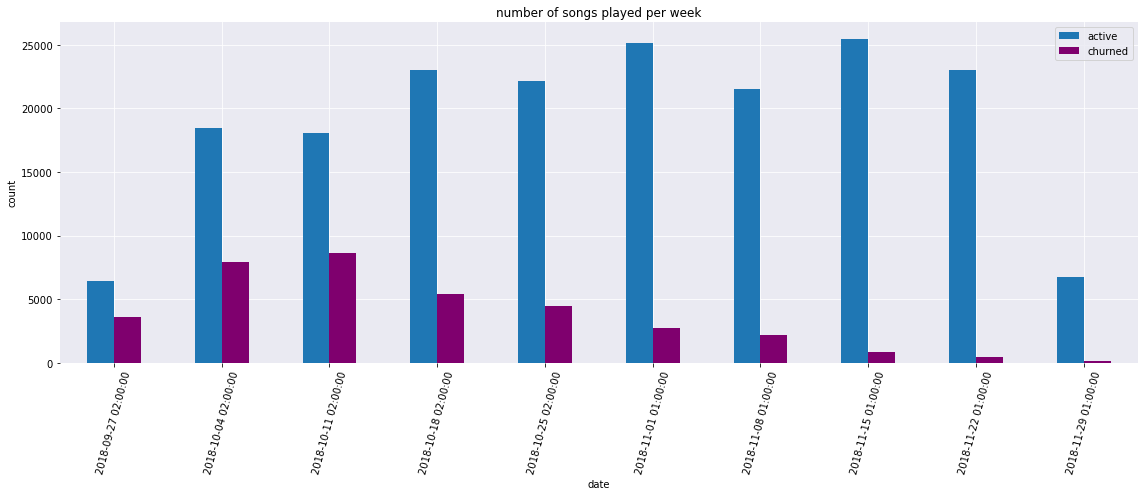

In [52]:
# plot a diagram
data_plot.plot(kind='bar', figsize=(16,7), color=[CONST_COLOR_1,CONST_COLOR_2], zorder=3)

plt.title("number of songs played per week")
plt.ylabel('count')
plt.xlabel('date')
plt.xticks(rotation=75)
plt.legend(loc='upper right')

plt.tight_layout()
plt.rcParams.update(pltParams)
plt.grid(True)
plt.show()

**Note**

- The number of songs played by `active users` remains constant on average.
- The number of songs played by `churned users` is low and slowly decreases over the time.

In [53]:
# examin encountered errors
data_churn_by_errors = data_user_log_valid.where( data_user_log_valid.page=='Error' ) \
                        .select('churned') \
                        .groupBy('churned') \
                        .count() \
                        .withColumnRenamed('count', 'numErrors') \
                        .sort('churned') \
                        .toPandas() \
                        .merge(data_churned_split)

data_churn_by_errors['avg_errors'] = data_churn_by_errors.numErrors / data_churn_by_errors.cnt

In [54]:
data_churn_by_errors

,churned,numErrors,cnt,avg_errors
0,active,216,173,1.248555
1,churned,32,52,0.615385


**Note**

- The error page displayed by "active users" is proportionally higher than the errors displayed by churned subscribers.
- Thus, this should not have a significant impact on the user's decision. Nevertheless, we should take this into account in the modeling.

<hr>

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**Note**

Up to this point, all users are identified as either Churners or Non-Churners. Thus, from this point in timet , some characteristics can be created and their distribution across the two groups of users can be compared.
If one then looks at the averages, for example how often users performed certain actions in periods such as two weeks, this indicates that the results obtained are comparatively similar. 
Instead, looking at actions per session proved to be more useful.

In [55]:
# extract: user lifetime since registration
data_user_lifetime = data_user_log_valid.select('userId','ts','registration') \
                        .groupBy('userId', 'registration') \
                        .agg((F.max( data_user_log_valid.ts - data_user_log_valid.registration) / (1000*3600*24)).alias('lifetime')) \
                        .select(['userId', 'lifetime'])

In [56]:
# extract: session count, average, minimum and maximum session duration
data_user_session_info = data_user_log_valid.groupBy('userId', 'sessionId') \
                            .agg((F.max( data_user_log_valid.ts ) - F.min( data_user_log_valid.ts )).alias('duration'))

data_user_session_info = data_user_session_info.groupBy('userId') \
                            .agg( F.count('sessionId').alias('sessionCount'), \
                             F.avg('duration').alias('averageSessionDuration'), \
                             F.max('duration').alias('maxSessionDuration'), \
                             F.min('duration').alias('minSessionDuration') )

In [57]:
# extract: number of songs played per session
data_user_avg_songs = data_user_log_valid.where( data_user_log_valid.page=='NextSong' ).groupBy('userId', 'sessionId').count()
data_user_avg_songs = data_user_avg_songs.groupBy('userId').agg(F.avg('count').alias('songsPerSession'))

In [58]:
# extract: number of songs added to playlist
data_user_playlist_count = data_user_log_valid.where( data_user_log_valid.page=='Add to Playlist') \
                            .groupBy('userId') \
                            .count() \
                            .withColumnRenamed('count', 'playlistCount')

In [59]:
# extract: number of errors encountered
data_user_error_count = data_user_log_valid.where( data_user_log_valid.page=='Error') \
                            .groupBy('userId') \
                            .count().withColumnRenamed('count', 'errorCount')

In [60]:
# extract: number of advertisements seen
data_user_ad_count = data_user_log_valid.where( data_user_log_valid.page=='Roll Advert') \
                        .groupBy('userId').count() \
                        .withColumnRenamed('count', 'adCount')

In [61]:
# extract: number of friends added
data_user_friends_count = data_user_log_valid.where( data_user_log_valid.page=='Add Friend') \
                            .groupBy('userId').count() \
                            .withColumnRenamed('count', 'friendCount')

In [62]:
# extract: number of thumbs up and thumbs own events
data_user_thumbsup_count = data_user_log_valid.where( data_user_log_valid.page=='Thumbs Up') \
                            .groupBy('userId').count() \
                            .withColumnRenamed('count', 'thumbsUpCount')

data_user_thumbsdown_count = data_user_log_valid.where( data_user_log_valid.page=='Thumbs Down') \
                            .groupBy('userId').count() \
                            .withColumnRenamed('count', 'thumbsDownCount')

In [63]:
# map the 'paid'/'free' to binary 1/0 values
func_levelMapper = F.udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

data_user_current_level = data_user_current_level.withColumn('level', func_levelMapper( data_user_current_level.level ))

**Note: Skip Forwarded or Not?**

With the assumption that the recommendation engine recommends the next song to the user, a good indicator could be the percentage length of the song listened to by the user for the effectiveness of the recommendation engine. This is because the actual dataset provides the time length of the song in seconds. Thus, the difference of the timestamps of the events could be calculated (for understanding: timestamp of the next event minus the timestamp of the current event) to make visible how long the user listened to the selected song. This is because the longer the user stays with the current song before finally switching to the next one, the better the recommendation, the better it is accepted by the user, and the greater the actual chance that the user will stay on this platform.

In [64]:
# set window
w = Window().partitionBy("userId","sessionId").orderBy("timestamp")
data_lag = data_user_log_valid.withColumn('next_ts',
                        F.lag( data_user_log_valid['ts'], -1).over(w))

data_user_log_valid = data_lag.withColumn('play_duration', 
                       ( data_lag['next_ts'] - data_lag['ts'] ) / ( data_lag['length']*1000 ))

data_user_avg_listen_length = data_user_log_valid.where( data_user_log_valid.page=='NextSong') \
                            .groupBy('userId') \
                            .agg(F.avg('play_duration').alias('avg_listen_length'))

In [65]:
func_genderMapper = F.udf(lambda x: 1 if x == 'M' else 0, IntegerType())
func_churnMapper  = F.udf(lambda x: 1 if x == 'churned' else 0, IntegerType())

data_users = data_user_log_valid.select('userId', 
                                        func_churnMapper('churned').alias('label'),
                                        func_genderMapper('gender').alias('gender')).dropDuplicates()

In [66]:
# create data container for modelling
data_modelling = data_users.join( data_user_lifetime, on='userId', how='left') \
                    .join( data_user_session_info, on='userId', how='left') \
                    .join( data_user_avg_songs, on='userId', how='left') \
                    .join( data_user_playlist_count, on='userId', how='left') \
                    .join( data_user_error_count, on='userId', how='left') \
                    .join( data_user_ad_count, on='userId', how='left') \
                    .join( data_user_friends_count, on='userId', how='left') \
                    .join( data_user_thumbsup_count, on='userId', how='left') \
                    .join( data_user_thumbsdown_count, on='userId', how='left') \
                    .join( data_user_avg_listen_length, on='userId', how='left') \
                    .join( data_user_current_level, on='userId', how='left') \
                    .drop('userId') \
                    .fillna(0)

**Note**

If a user has not performed a certain action, e.g. thumbs up/thumbs down or add to playlist, 
the corresponding value is set to NULL by linking. 
This effect can be seen in the "engineered count" and "average" columns. We can safely populate these values with 0.

In [67]:
data_modelling.printSchema()

root
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- lifetime: double (nullable = false)
 |-- sessionCount: long (nullable = true)
 |-- averageSessionDuration: double (nullable = false)
 |-- maxSessionDuration: long (nullable = true)
 |-- minSessionDuration: long (nullable = true)
 |-- songsPerSession: double (nullable = false)
 |-- playlistCount: long (nullable = true)
 |-- errorCount: long (nullable = true)
 |-- adCount: long (nullable = true)
 |-- friendCount: long (nullable = true)
 |-- thumbsUpCount: long (nullable = true)
 |-- thumbsDownCount: long (nullable = true)
 |-- avg_listen_length: double (nullable = false)
 |-- level: integer (nullable = true)



In [68]:
data_modelling.write.save( CONST_PROCESSED_DATAFILE, format="json", mode="overwrite" )

<hr>

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [69]:
data_modelling = spark.read.json( CONST_PROCESSED_DATAFILE )

**Note: Selecting the evaluation metric**

Since this is a binary classification problem, Accuracy, Recall, Precision, f1 score, or Area under ROC curve should be considered as possible scoring metrics.

The area under ROC and Accuracy work best when the labels are balanced. The target variable 'churned' is skewed with 76% negative and 24% positive cases. Therefore, Accuracy or Area under ROC curve cannot be used well enough as a metric.

In [70]:
def func_getMetrics(df):
    TP = df[(df.label==1) & (df.prediction==1)].shape[0]
    TN = df[(df.label==0) & (df.prediction==0)].shape[0]
    FP = df[(df.label==0) & (df.prediction==1)].shape[0]
    FN = df[(df.label==1) & (df.prediction==0)].shape[0]
    
    accuracy    = (TP+TN)/(TP + TN + FP + FN)
    precision   = 0 if (TP+FP)==0 else TP/(TP+FP)
    recall      = 0 if (TP+FN)==0 else TP/(TP+FN)
    specificity = 0 if (TN+FP)==0 else TN/(TN+FP)
    f1_score    = 0 if (precision + recall)==0 else (2*precision*recall) / (precision + recall)
    
    result = {'accuracy': accuracy, 'precision':precision, 'recall': recall, 'specificity': specificity, 'f1_score': f1_score}
    return result
# -----------------------

df = data_modelling.select('label').toPandas()
df['prediction'] = 0
results_pred_0 = func_getMetrics(df)

df['prediction'] = 1
results_pred_1 = func_getMetrics(df)

print('======================Naive Prediction Scores======================')
print('Predict - No Churning:\n {}\n'.format( results_pred_0 ) )
print('Predict - Everybody as Churned:\n {}'.format( results_pred_1 ) )

======================Naive Prediction Scores======================
Predict - No Churning:
 {'accuracy': 0.7688888888888888, 'precision': 0, 'recall': 0.0, 'specificity': 1.0, 'f1_score': 0}

Predict - Everybody as Churned:
 {'accuracy': 0.2311111111111111, 'precision': 0.2311111111111111, 'recall': 1.0, 'specificity': 0.0, 'f1_score': 0.37545126353790614}


**Note**

An attempt should be made to capture as many churned users as possible, as it is not desired that these users churn. However, classifying all users as `churned` would be counterproductive, as Sparkify would end up offering discounts to all users, resulting in lost revenue. Thus, this strategy does not work. Something else needs to be done.

An attempt must be made to maximize both Precision and Recall scores. A balancing F1 score thus seems to be the most appropriate measure for evaluating the model.

A naive set of predictions yielded an F1 score of 0 (based on prediction of no churn) and a value of approximately 0.38 when predicting complete churn. Applying supervised learning techniques, one can see if a model can have a better prediction than this one. This would be a possibility.

### Vectorize and Scale

In [71]:
feature_columns = [col for col in data_modelling.columns if col != 'label']

assembler = VectorAssembler( inputCols=feature_columns, outputCol='FeatureVector' )
data_modelling = assembler.transform( data_modelling )

In [72]:
std_scaler  = StandardScaler( inputCol="FeatureVector", outputCol="features", withStd=True )
train, test = data_modelling.randomSplit([0.7, 0.3], seed=42)

scalerModel = std_scaler.fit( train )
train = scalerModel.transform( train ).select( F.col('features'), F.col('label')).persist()
test  = scalerModel.transform( test ).select( F.col('features'), F.col('label')).persist()

Implement some helper functions:

In [73]:
class F1Score_Evaluator(Evaluator):

    def __init__(self, predictionCol="prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol      = labelCol
    # -----------------------

    def _evaluate(self, dataset):
        """
        Returns a random number. 
        Implement here the true metric
        """
        return func_getMetrics(dataset.select('label', 'prediction').toPandas())['f1_score']
    # -----------------------

    def isLargerBetter(self):
        return True
    # -----------------------
# -----------------------

In [74]:
def func_trainModel(train_data, test_data, estimator, paramGrid=None):
    estimatorName = estimator.__class__.__name__
    evaluator     = F1Score_Evaluator()
    
    if paramGrid != None:
        estimator = CrossValidator(estimator=estimator,
                                   estimatorParamMaps=paramGrid,
                                   evaluator=evaluator,
                                   numFolds=3)
    # --- then ---
      
    model      = estimator.fit( train_data )
    train_pred = model.transform( train_data )
    test_pred  = model.transform( test_data )
    train_f1   = evaluator.evaluate( train_pred );
    test_f1    = evaluator.evaluate( test_pred );
    
    result     = {'estimator': estimatorName, 'train_f1': train_f1, 'test_f1': test_f1, 'model': model}
    return result

In [75]:
def func_showResult(result):
    print('estimator      : {}'.format( result["estimator"] ))
    print('train f1-score : {}'.format( result["train_f1"] ))
    print('test  f1-score : {}'.format( result["test_f1"] ))
    print('Model          : {}'.format( result["model"] ))

**Note**

In the next step, we will evaluate different machine learning models for the f1 score to get a first impression of them. After that, the best models will be selected and further optimized.

In [76]:
results = []

# all machine learning algos which are to be investigated
all_algo = [LogisticRegression(), \
            RandomForestClassifier( seed=49 ), \
            GBTClassifier( seed=49 ), \
            DecisionTreeClassifier( seed=49 ), \
            NaiveBayes()]


# interate over each algo and get a result of trainModel
for algo in all_algo:
    result = func_trainModel(train, test, algo, None)  # train the model
    results.append(result)                             # store result
    func_showResult(result)                            # show the result
    print('--------------------------------------\n')
# ---- for ----

estimator      : LogisticRegression
train f1-score : 0.5172413793103448
test  f1-score : 0.5
Model          : LogisticRegressionModel: uid=LogisticRegression_310af2ed2575, numClasses=2, numFeatures=15
--------------------------------------

estimator      : RandomForestClassifier
train f1-score : 0.819672131147541
test  f1-score : 0.2
Model          : RandomForestClassificationModel: uid=RandomForestClassifier_3fd0e2a012ad, numTrees=20, numClasses=2, numFeatures=15
--------------------------------------

estimator      : GBTClassifier
train f1-score : 1.0
test  f1-score : 0.37037037037037035
Model          : GBTClassificationModel: uid = GBTClassifier_16b72186abce, numTrees=20, numClasses=2, numFeatures=15
--------------------------------------

estimator      : DecisionTreeClassifier
train f1-score : 0.8529411764705883
test  f1-score : 0.25
Model          : DecisionTreeClassificationModel: uid=DecisionTreeClassifier_728deddf871f, depth=5, numNodes=27, numClasses=2, numFeatures=15
----

### Results of all 5 Classifiers for the first impression

In [77]:
pd_results = pd.DataFrame(results)

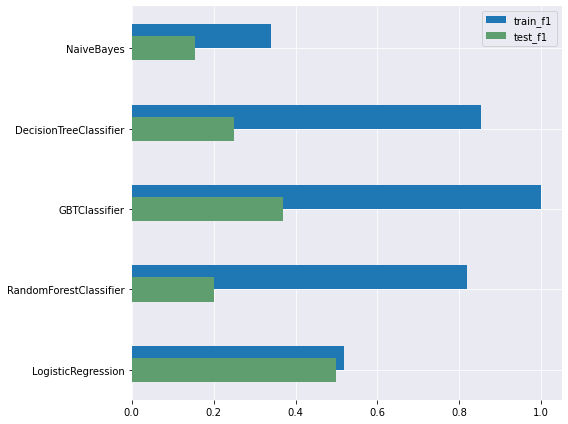

In [78]:
# plot a diagram
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(pd_results['estimator'], pd_results['train_f1'], 0.3, align='edge', color=CONST_COLOR_1, label='train_f1', zorder=3)
ax.barh(pd_results['estimator'], pd_results['test_f1'], 0.3, align='center', color=CONST_COLOR_3, label='test_f1', zorder=3)

plt.legend(loc='upper right')
plt.tight_layout()
plt.rcParams.update(pltParams)
plt.grid(True)
plt.show()

**Note**

As can be seen, the algorithms gave different results:

`LogisticRegression` has an almost equal F1 score between training and test sets. The `GBTClassifier` and `DecisionTreeClassifier` both have a high training F1 score and better test results compared to `RandomForestClassfier`. The `NaiveBayes` shows very poor training and test results. This algorithm should not be further supported.

### Further optimizations of the 3 best machine learning models

**Note**

The next steps are to apply supervised learning techniques to clarify if a model can be created with a better prediction than the previous result. To further improve the performance of the chosen model, I tuned the hyperparameters in advance. This took some more time and effort.

In [79]:
tunedResults=[]

### Classifier: RandomForest

In [80]:
# RandomForestClassifier
algo = RandomForestClassifier(seed=49)

paramGrid = ParamGridBuilder() \
            .addGrid(algo.maxDepth,[2, 3, 5]) \
            .addGrid(algo.minInstancesPerNode,[1,2,3]) \
            .addGrid(algo.maxBins, [4, 8, 16, 32]) \
            .build()

result = func_trainModel(train, test, algo, paramGrid)  # train the model
tunedResults.append(result)                             # store results for plotting
func_showResult(result)                                 # show results

estimator      : RandomForestClassifier
train f1-score : 0.819672131147541
test  f1-score : 0.2
Model          : CrossValidatorModel_7efe560aa489


### Classifier: DecisionTree

In [81]:
# DecisionTreeClassifier
algo = DecisionTreeClassifier(seed=49)

paramGrid = ParamGridBuilder() \
            .addGrid(algo.maxDepth,[2, 3, 5]) \
            .addGrid(algo.minInstancesPerNode,[1,2,3]) \
            .addGrid(algo.maxBins, [4, 8, 16, 32]) \
            .build()

result = func_trainModel(train, test, algo, paramGrid)  # train the model
tunedResults.append(result)                             # store results for plotting
func_showResult(result)                                 # show results

estimator      : DecisionTreeClassifier
train f1-score : 0.6944444444444444
test  f1-score : 0.5161290322580646
Model          : CrossValidatorModel_1a9847f69981


### Classifier: GBT

In [82]:
# GBTClassifier
algo = GBTClassifier(seed=49)

paramGrid = ParamGridBuilder() \
            .addGrid(algo.maxDepth,[2, 3, 5]) \
            .addGrid(algo.minInstancesPerNode,[1,2,3]) \
            .addGrid(algo.maxBins, [4, 8, 16, 32]) \
            .build()

result = func_trainModel(train, test, algo, paramGrid)  # train the model
tunedResults.append(result)                             # store results for plotting
func_showResult(result)                                 # show results

estimator      : GBTClassifier
train f1-score : 0.8437500000000001
test  f1-score : 0.2727272727272727
Model          : CrossValidatorModel_cf10bce495cb


### Results of all 3 Classifiers

In [83]:
df_tunedResults = pd.DataFrame(tunedResults)

In [84]:
df_tunedResults.head()

,estimator,train_f1,test_f1,model
0,RandomForestClassifier,0.819672,0.200000,CrossValidatorModel_7efe560aa489
1,DecisionTreeClassifier,0.694444,0.516129,CrossValidatorModel_1a9847f69981
2,GBTClassifier,0.843750,0.272727,CrossValidatorModel_cf10bce495cb


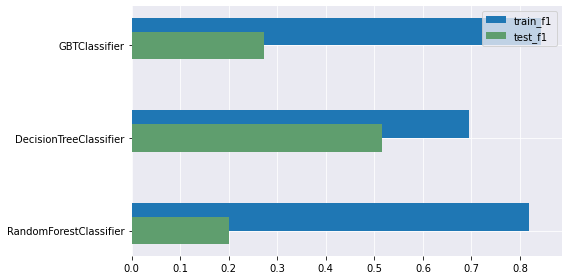

In [85]:
# plot a diagram
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(df_tunedResults['estimator'], df_tunedResults['train_f1'], 0.3, align='edge', color=CONST_COLOR_1, label='train_f1', zorder=3)
ax.barh(df_tunedResults['estimator'], df_tunedResults['test_f1'], 0.3, align='center', color=CONST_COLOR_3, label='test_f1', zorder=3)

plt.legend(loc='upper right')
plt.tight_layout()
plt.rcParams.update(pltParams)
plt.grid(True)
plt.show()

**Note**

The GBTClassifier shows the best results with these parameters, but as a drawback it needs much more runtime / computation time than the other two classifiers. This seems to be probably still an overfitting and the F1 score on the test data is not so good. As a solution idea, we should consider further development of more relevant features and perhaps even stagger the features over time to see if the trend over time can provide a better indication or a more significant result on user churn.

### Feature Importance

Finally, we can check the feature importance for our best model and plot this in a chart.

In [86]:
featureImportances = result['model'].bestModel.featureImportances
x_values = list(range(len(featureImportances)))

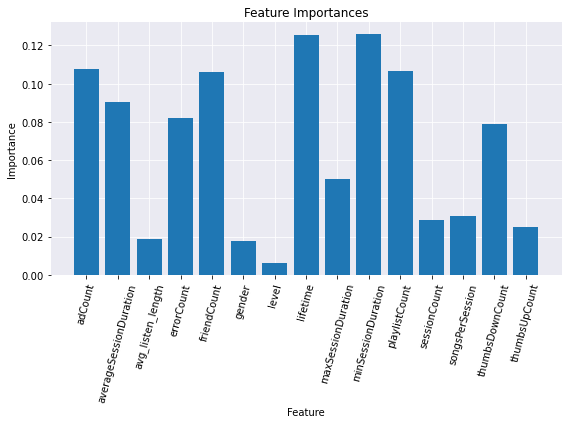

In [87]:
# plot a diagram
plt.figure(figsize=[8,6])

plt.bar(x_values, featureImportances, orientation = 'vertical', zorder=3)
plt.xticks(x_values, feature_columns, rotation=75)

plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

plt.tight_layout()
plt.rcParams.update(pltParams)
plt.grid(True)
plt.show()

**Note**

Here we can see that the feature with the highest importance was `lifetime`. Gender and level were the least important features.

<hr>

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

My blog post is [here](https://danieljaensch.medium.com/how-can-user-churn-on-the-sparkify-platform-be-predicted-with-pyspark-b0987165dff5).

### Project Reflection
After feature engineering, I used the same data frame again for another split into test and training data with a subsequent model training. It took a bit longer on this one, even for smaller data sets. It seems more obvious now that the training iterations take longer, since the entire transformation pipeline has to be run each time. Persisting the dataset with constructed features and reloading it would speed up model training. 

### Other improvements or Future work
Several features for training such as songs heard per session or average session duration were averaged for the entire period. Thus, a further breakdown by week could also reveal interesting trends, where decreasing session duration over the period could be a better indicator of users at risk of churn. This could then also further improve the accuracy of the model.

Other additional information about the user profile, such as the user's age group, interests, or even other habits, would have been very useful if available. From this, it could be even better to extract his behavior or even the personal hidden reasons why the user acts the way he does. This could again allow conclusions to be drawn about the implementation of appropriate market strategies.

Furthermore, one could also derive or find out the genre of the song of the title or artist. Because if users who do not like a certain genre migrate more frequently, this could also be an indication of problems with the recommendation engine. Thus, the algorithm could be extended here again in a more personalized way.

These are all additional possibilities for further development.